### Gaussian and T Copula

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from scipy.stats import t, multivariate_t

#### Guassian Copula

**Key idea**: To sample a Gaussian copula, we:
1. Create correlated standard normal samples $(Z_1, Z_2, ..., Z_d)$ using a covariance matrix.
2. Convert them to uniform variables via the standard normal CDF.

1. **Dimensionality**: The function infers the number of dimensions ($d$) from the size of the provided `correlation_matrix`. A valid correlation matrix should be $d \times d$, symmetric, and positive semi-definite with diagonal entries all equal to 1.

2. **Drawing Multivariate Normal Samples**:
   - We use `scipy.stats.multivariate_normal.rvs` to generate samples from a $d$-dimensional normal distribution.
   - The mean vector is set to the $d$-dimensional zero vector, and the covariance is set to the user-provided `correlation_matrix`.

3. **Transforming to [0,1]**:
   - Each component of the sampled vectors is mapped through the standard normal CDF, $\Phi$, which maps real values in $(-\infty, \infty)$ to $(0,1)$. This step yields uniform marginals, but retains the correlation structure from the original normal samples, resulting in a **Gaussian copula**.

4. **Return Value**: The function returns a NumPy array `U` of shape $(\text{sample_size}, d)$, where each entry is in $[0,1]$. Each row is one sample from the Gaussian copula.

In [2]:
def gaussian_copula_samples(correlation_matrix, sample_size=1000):
    """
    Generate samples from a Gaussian copula with the specified correlation structure.

    Parameters
    ----------
    correlation_matrix : np.ndarray
        A (dim x dim) matrix representing the correlation structure.
        This matrix should be symmetric and positive semi-definite.
        The dimension (dim) is inferred from correlation_matrix.shape[0].

    sample_size : int, optional (default=1000)
        Number of samples to generate.

    Returns
    -------
    U : np.ndarray
        A 2D array of shape (sample_size, dim), where dim is the dimension of
        the copula (inferred from the size of `correlation_matrix`). Each entry
        in U lies in the interval [0, 1]. The rows correspond to individual
        samples, and the columns correspond to each dimension of the Gaussian
        copula.
        
    Notes
    1. The sampling process:
       - Draw `sample_size` points from a dim-dimensional multivariate normal
         distribution with mean vector 0 and covariance given by `correlation_matrix`.
       - Apply the standard normal CDF (Φ) element-wise to map each dimension
         from (-∞, ∞) to (0, 1).
    2. If you want different marginal distributions (e.g., gamma, beta), you can
       transform each column in U via the inverse CDF of the desired distribution.
    3. Ensure that `correlation_matrix` is a valid correlation matrix (i.e.,
       symmetric, positive semi-definite, and diagonal entries are all 1).

  
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.stats import pearsonr
    >>> # Define a 2x2 correlation matrix with correlation = 0.7
    >>> corr = np.array([[1.0, 0.7],
    ...                  [0.7, 1.0]])
    >>> # Generate 500 samples
    >>> U = gaussian_copula_samples(corr, sample_size=500)
    >>> print(U.shape)
    (500, 2)
    >>> # Check that each dimension is roughly uniform
    >>> # and that the correlation structure is preserved:
    >>> print(U.min(), U.max())  # Should be between 0 and 1
    >>> print(pearsonr(U[:, 0], U[:, 1]))  # Should be close to 0.7
    """
    # Determine the dimensionality from the shape of the correlation matrix
    dim = correlation_matrix.shape[0]

    # 1) Draw 'sample_size' samples from a multivariate normal with:
    #    - mean vector: zeros (dim)
    #    - covariance matrix: correlation_matrix
    Z = multivariate_normal.rvs(mean=np.zeros(dim),
                                cov=correlation_matrix,
                                size=sample_size)

    # 2) Map each coordinate to [0,1] using the standard normal CDF
    U = norm.cdf(Z)

    return U

#### T - Copula

**Key idea**: Similar to the Gaussian copula, but instead of sampling from a multivariate normal, we sample from a multivariate $t$-distribution with $\nu$ degrees of freedom (df or dof). Then we use the $t$-CDF to map them to uniforms.

- We specify the correlation $\rho$ and degrees of freedom ($\nu$).
- We draw samples from a multivariate $t$-distribution.
- We map those correlated $t$ variates to uniforms via the $t$-CDF, giving us a T-copula.

In [3]:
def t_copula_samples(correlation_matrix, df=1, sample_size=1000):
    """
    Generate samples from a t copula using a specified correlation structure
    (or scale matrix) and degrees of freedom.

    Parameters
    ----------
    correlation_matrix : np.ndarray
        A (dim x dim) matrix representing the correlation (or scale) structure
        for the multivariate t distribution. Should be symmetric and positive
        semi-definite. The dimension (dim) is inferred from
        correlation_matrix.shape[0].

    df : float, optional (default=1)
        Degrees of freedom (ν) for the t distribution. Lower values produce
        heavier tails.

    sample_size : int, optional (default=1000)
        Number of samples to generate.

    Returns
    -------
    U : np.ndarray
        A 2D array of shape (sample_size, dim), where `dim` is the dimension
        of the copula (inferred from the size of `correlation_matrix`). Each
        entry lies in the interval [0, 1]. The rows correspond to individual
        samples, and the columns correspond to each dimension of the t copula.

    Notes
    -----
    1. The sampling process here assumes the existence of a `multivariate_t.rvs`
       function, which is not part of the standard SciPy library. This function
       takes a mean vector, a scale (or correlation) matrix, and a degrees-of-freedom
       parameter and returns multivariate t samples.
    2. After drawing from the multivariate t, each dimension is mapped through
       the univariate t CDF (with the same df) to obtain values in [0, 1].
    3. Ensure that `correlation_matrix` is a valid correlation or scale matrix
       for the t distribution.
    4. If you want different marginals (e.g., gamma, beta), transform each
       column in U via the inverse CDF of the desired marginal distribution.

    Examples
    --------
    >>> import numpy as np
    >>> # Suppose 'multivariate_t.rvs' is properly implemented
    >>> # Define a 2x2 correlation matrix
    >>> corr = np.array([[1.0, 0.5],
    ...                  [0.5, 1.0]])
    >>> # Generate 500 samples from a t distribution with df=3
    >>> U = t_copula_samples(corr, df=3, sample_size=500)
    >>> print(U.shape)
    (500, 2)
    >>> # Check that each dimension is in [0, 1]
    >>> print(U.min(), U.max())  # Should be between 0 and 1
    """
    # Determine the dimensionality from the shape of the correlation matrix
    dim = correlation_matrix.shape[0]

    # 1) Draw 'sample_size' samples from a multivariate t distribution with:
    #    - mean vector: zeros (dim)
    #    - scale (correlation) matrix: correlation_matrix
    #    - degrees of freedom: df
    T = multivariate_t.rvs(np.zeros(dim),
                           correlation_matrix,
                           df=df,
                           size=sample_size)

    # 2) Convert each coordinate to [0,1] using the t CDF with the same df
    U = t.cdf(T, df)

    return U

#### Test Multivariate normal, Gaussian Copula and T - Copula
Let's generate 2D sample of size 1000 from Multivariate normal, Gaussian Copula and T - Copula given,
1. $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}, \rho = 0.5$
2. $df = 5$

and plot

In [4]:

rho = 0.5
cov_2d = np.array([[1,   rho],
                   [rho, 1  ]])
sample_size = 1000

# Draw from the bivariate normal directly
normal_samples = np.random.multivariate_normal(mean=[0, 0], cov=cov_2d, size=sample_size)
x_norm = normal_samples[:, 0]
y_norm = normal_samples[:, 1]

# -------------------------------
# 2) Gaussian Copula
# -------------------------------
U_gauss = gaussian_copula_samples(correlation_matrix=cov_2d, sample_size=sample_size)
x_gauss = U_gauss[:, 0]
y_gauss = U_gauss[:, 1]

# -------------------------------
# 3) t Copula
# -------------------------------
df_t = 5
U_t = t_copula_samples(correlation_matrix=cov_2d, df=df_t, sample_size=sample_size)
x_t = U_t[:, 0]
y_t = U_t[:, 1]

In [5]:
import matplotlib.pyplot as plt

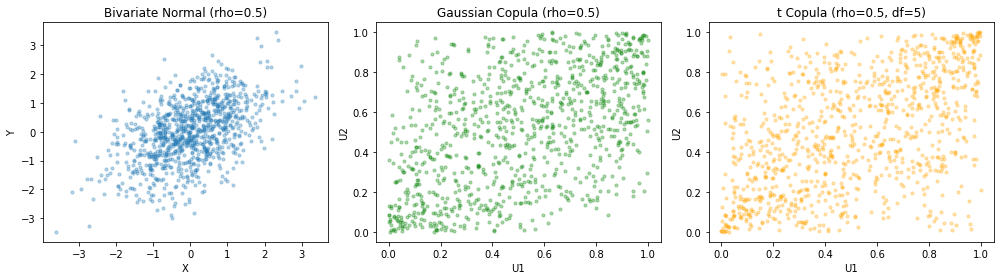

In [6]:
# -------------------------------
# Plot each set of samples
# -------------------------------
plt.figure(figsize=(14, 4))

# Subplot 1: Bivariate Normal
plt.subplot(1, 3, 1)
plt.scatter(x_norm, y_norm, alpha=0.3, s=10)
plt.title(f"Bivariate Normal (rho={rho})")
plt.xlabel("X")
plt.ylabel("Y")

# Subplot 2: Gaussian Copula (U in [0,1]^2)
plt.subplot(1, 3, 2)
plt.scatter(x_gauss, y_gauss, alpha=0.3, s=10, color='green')
plt.title(f"Gaussian Copula (rho={rho})")
plt.xlabel("U1")
plt.ylabel("U2")

# Subplot 3: t Copula (U in [0,1]^2)
plt.subplot(1, 3, 3)
plt.scatter(x_t, y_t, alpha=0.3, s=10, color='orange')
plt.title(f"t Copula (rho={rho}, df={df_t})")
plt.xlabel("U1")
plt.ylabel("U2")

plt.tight_layout()
plt.show()

These three plots illustrate three different ways of generating pairs of random variables that share roughly the **same correlation** ($\rho = 0.5$) but differ in how their marginal distributions and tail behaviors are specified:

1. **Bivariate Normal (left)**  
   - Plots samples $(X, Y)$ drawn directly from a **2D normal distribution** with correlation $\rho = 0.5$.  
   - Notice the elliptical “cloud” of points, centered roughly at $(0,0)$. The spread along the diagonal indicates that as $X$ increases, $Y$ also tends to increase, reflecting positive correlation.
   - The $x$-axis and $y$-axis both span real values (negative to positive).

2. **Gaussian Copula (center)**  
   - Plots samples $(U_1, U_2)$ where each coordinate is in the unit interval $[0,1]$.  
   - These points were generated by first drawing from a **multivariate normal** with correlation $\rho = 0.5$, then mapping each dimension through the standard normal CDF.  
   - The result is that each margin is **uniform** on $[0,1]$, but the points maintain the same correlation structure (about 0.5).  
   - Visually, you see a moderate positive trend in $(U_1, U_2)$, but no visible concentration near the edges because the marginal distributions are uniform.

3. **t Copula (right)**  
   - Similar to the Gaussian copula setup, except the correlated samples come from a **multivariate $t$** distribution with correlation $\rho = 0.5$ and degrees of freedom $\nu = 5$.  
   - After drawing those $t$-distributed samples, each coordinate is mapped to $[0,1]$ by the univariate $t$-CDF.  
   - Margins are again **uniform** on $[0,1]$, but the dependence structure is different in the tails: a **t** copula tends to have heavier tail dependence than the Gaussian copula.  
   - With $\nu=5$, the difference in the scatter may not be huge compared to the Gaussian case, but over many draws or more extreme values of $\nu$ (like 2 or 3), you might see more points clustering near the corners (i.e., stronger tail dependence).

In [7]:
class Empirical:
    """
    A class representing an empirical distribution constructed from a sample of data.

    The distribution is fully defined by the sample provided at initialization.
    Both the CDF (cumulative distribution function) and the inverse CDF (quantile
    function) are computed directly from this sample.

    Parameters
    ----------
    sample : array-like
        A one-dimensional collection of numeric data points. This data is used
        to define the empirical distribution, and will be internally sorted.

    Attributes
    ----------
    _sample : list of float
        The sorted input sample.
    _size : int
        The number of data points in the sample.

    Methods
    -------
    cdf(x)
        Computes the empirical CDF at one or more points x.
    inv_cdf(p)
        Computes the empirical inverse CDF (quantile function) at one or more
        probability levels p.

    Notes
    -----
    - The CDF, F(x), at a point x is the proportion of sample values <= x.
    - The inverse CDF (quantile) at probability p is the sample value
      corresponding (roughly) to the p-th percentile, determined by indexing
      into the sorted sample.
    - Input values can be single scalars, Python lists, NumPy arrays, or pandas Series.

    Examples
    --------
    >>> data = [2.3, 1.7, 3.6, 2.1, 2.9]
    >>> dist = Empirical(data)
    >>> # Single value CDF
    >>> print(dist.cdf(2.1))
    0.4  # (2 out of 5 samples are <= 2.1)
    >>> # Array of x values
    >>> import numpy as np
    >>> xs = np.array([1.5, 2.5, 3.5])
    >>> print(dist.cdf(xs))
    [0.2 0.6 0.8]
    >>> # Single value inverse CDF (e.g., median ~ p=0.5)
    >>> print(dist.inv_cdf(0.5))
    2.3
    >>> # Probability array
    >>> ps = [0.2, 0.5, 0.8]
    >>> print(dist.inv_cdf(ps))
    [1.7, 2.3, 3.6]
    """

    def __init__(self, sample):
        """
        Initialize the empirical distribution from a given sample.

        Parameters
        ----------
        sample : array-like
            The sample data used to build the empirical distribution.
            Must be a sequence of numeric values.
        """
        # Sort the sample so we can easily perform quantile lookups.
        self._sample = sorted(sample)
        # Store the sample size for quick reference.
        self._size = len(sample)

    def cdf(self, x):
        """
        Compute the empirical CDF for one or more points x.

        The empirical CDF at a point x is the fraction of sample points that
        are <= x.

        Parameters
        ----------
        x : int, float, np.ndarray, pd.Series, or list
            The point(s) at which the CDF is evaluated.
            - If x is a scalar (int/float), returns a single float in [0, 1].
            - If x is array-like (NumPy array, pandas Series, or list),
              returns the same structure containing CDF values in [0, 1].

        Returns
        -------
        float or array-like
            The empirical CDF value(s). The output type matches the input type
            (scalar, array, Series, or list).

        Examples
        --------
        >>> dist = Empirical([1, 2, 3, 4, 5])
        >>> dist.cdf(3)
        0.6
        >>> xs = np.array([2, 4])
        >>> dist.cdf(xs)
        array([0.4, 0.8])
        """
        # Define a helper function for single-value input.
        def _cdf_single(val):
            # Count how many sample points are <= val
            count = sum(1 for s in self._sample if s <= val)
            return count / self._size

        if isinstance(x, (int, float, np.number)):
            # If x is a single numeric scalar
            return _cdf_single(x)

        elif isinstance(x, np.ndarray):
            # Vectorize the helper to handle arrays
            return np.vectorize(_cdf_single)(x)

        elif isinstance(x, pd.Series):
            # Apply the helper to each element of a Series
            return x.apply(_cdf_single)

        elif isinstance(x, list):
            # List comprehension for plain Python lists
            return [_cdf_single(v) for v in x]

        else:
            # Unrecognized input type
            raise TypeError("Input type not supported. Provide a numeric scalar, "
                            "list, NumPy array, or pandas Series.")

    def inv_cdf(self, p):
        """
        Compute the empirical inverse CDF (quantile function) for one or more probabilities p.

        This method returns the empirical quantiles, as determined by indexing
        into the sorted sample. It uses the formula:

            index = int(p * size + 0.5) - 1

        clamped to [0, size-1] to avoid out-of-bounds errors, and returns the
        sample value at this index.

        Parameters
        ----------
        p : int, float, np.ndarray, pd.Series, or list
            The probability level(s) for which the quantile(s) will be computed.
            - If p is a scalar, returns a single float.
            - If p is array-like (NumPy array, pandas Series, or list),
              returns the same structure containing the corresponding quantiles.

        Returns
        -------
        float or array-like
            Empirical quantile(s). The output type matches the input type
            (scalar, array, Series, or list).

        Examples
        --------
        >>> dist = Empirical([1, 2, 3, 4, 5])
        >>> dist.inv_cdf(0.5)
        2
        >>> ps = [0.0, 0.25, 0.5, 1.0]
        >>> dist.inv_cdf(ps)
        [1, 2, 2, 5]
        """
        # Define a helper function for single-value input.
        def _inv_cdf_single(prob):
            # Compute index from the probability, rounding
            idx = int(prob * self._size + 0.5) - 1
            # Clamp the index to [0, size-1]
            idx = min(max(0, idx), self._size - 1)
            return self._sample[idx]

        if isinstance(p, (int, float, np.number)):
            # If p is a single numeric scalar
            return _inv_cdf_single(p)

        elif isinstance(p, np.ndarray):
            # Vectorize the helper for arrays
            return np.vectorize(_inv_cdf_single)(p)

        elif isinstance(p, pd.Series):
            # Apply the helper to each element of a Series
            return p.apply(_inv_cdf_single)

        elif isinstance(p, list):
            # List comprehension for plain Python lists
            return [_inv_cdf_single(v) for v in p]

        else:
            # Unrecognized input type
            raise TypeError("Input type not supported. Provide a numeric scalar, "
                            "list, NumPy array, or pandas Series.")


#### Example
 
Given a dataset (either a DataFrame or a 2D array), generate random samples for each column by using a copula-based approach. In this example, each column’s marginal distribution is modeled empirically, but you could easily substitute any other distribution.

**Steps**  
1. **Correlation Extraction**: Compute the correlation matrix from the dataset.  
2. **Copula Sampling**: Generate uniform samples $[0,1]^d$ from a Gaussian or t copula, using the estimated correlation.  
3. **Marginal Mapping**: Convert each dimension of the copula samples back to the empirical distribution of the corresponding column, thus preserving both the marginal distributions and their approximate dependence structure.

In [8]:
def simulate_using_copula(data, sample_size=1000, copula_type="Gaussian", dof=1):
    """
    Generate synthetic data by sampling from a specified copula (Gaussian or T)
    and mapping the samples to the empirical distributions of the original dataset.

    This function:
    1. Extracts a correlation matrix from the input data.
    2. Uses either a Gaussian or t copula to generate uniform samples in [0,1]^d
       that share the same correlation structure.
    3. Maps each dimension of these uniform samples to the empirical distribution
       of the corresponding column in the original data, preserving marginal
       distributions and approximate dependence.

    Parameters
    ----------
    data : pd.DataFrame, np.ndarray, or array-like
        The input dataset from which to extract correlation and marginal
        distributions.
        - If data is a pandas DataFrame, the columns are treated individually.
        - If data is a 2D NumPy array, its columns are treated individually.
        - Otherwise, data is converted to a NumPy array with shape (n_samples, n_features).

    sample_size : int, optional (default=1000)
        The number of synthetic samples to generate.

    copula_type : str, optional (default='gaussian')
        The type of copula to use. Must be either 'gaussian' or 't'.

    dof : float, optional (default=1)
        Degrees of freedom for the t copula. Ignored unless `copula_type` is 't'.

    Returns
    -------
    pd.DataFrame or np.ndarray
        A new dataset of size (sample_size, n_features) with the same marginal
        distributions and correlation structure as the original data.
        - If the input is a pandas DataFrame, the output is also a DataFrame
          with the same column names.
        - Otherwise, the output is a NumPy array.

    Notes
    -----
    - The correlation matrix is computed using `np.corrcoef`, which is a Pearson
      correlation estimate based on the original data.
    - For the Gaussian copula, we use `gaussian_copula_samples`.
    - For the t copula, we use `t_copula_samples` with `dof` degrees of freedom.
    - After generating uniform samples (U) in [0,1]^d, we map each dimension
      through the empirical inverse CDF of the corresponding column from the
      original data, so that each synthetic column reproduces the empirical
      marginal distribution seen in the original dataset.
    - Ensure that you have defined and imported:
        - `gaussian_copula_samples(...)`
        - `t_copula_samples(...)`
        - `Empirical(...)`
      in your environment.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> # Suppose we have a DataFrame with 3 columns of real data:
    >>> df_original = pd.DataFrame({
    ...     'A': np.random.normal(0, 1, 500),
    ...     'B': np.random.gamma(2, 2, 500),
    ...     'C': np.random.uniform(0, 10, 500)
    ... })
    >>> # Generate 1000 synthetic samples using a Gaussian copula:
    >>> df_synthetic = simulate_using_copula(df_original, sample_size=1000)
    >>> print(df_synthetic.head())
    >>> # Generate 500 synthetic samples using a t copula with df=5:
    >>> df_synthetic_t = simulate_using_copula(df_original, sample_size=500,
    ...                                        copula_type='t', dof=5)
    >>> print(df_synthetic_t.head())
    """
    # Convert data to appropriate NumPy array form if necessary.
    if isinstance(data, pd.DataFrame):
        # If the input is a DataFrame, preserve the columns for later
        X = data.values
    elif isinstance(data, np.ndarray):
        # If it's already a 2D array, just assign it to X
        if data.ndim == 2:
            X = data
        else:
            raise ValueError("Input NumPy array must be 2D.")
    else:
        # Otherwise, convert to NumPy array (2D).
        X = np.array(data)
        if X.ndim != 2:
            raise ValueError("Input data could not be converted to a 2D array.")

    # 1) Estimate the correlation matrix of the original data
    _corr = np.corrcoef(X, rowvar=False)

    # 2) Generate uniform samples from the chosen copula
    if copula_type.lower() == "gaussian":
        U = gaussian_copula_samples(_corr, sample_size)
    elif copula_type.lower() == "t":
        U = t_copula_samples(_corr, df=dof, sample_size=sample_size)
    else:
        raise ValueError("copula_type must be either 'Gaussian' or 'T'.")

    # _dim corresponds to number of features (columns)
    _dim = _corr.shape[0]
    # Create an array of column indices for reference
    col_indices = np.arange(_dim)

    # 3) For each column: map uniform samples through the empirical inverse CDF
    #    of that column in the original data
    for i in col_indices:
        column = X[:, i]       # Extract the original data for the ith column
        u = U[:, i]            # The uniform samples for the ith dimension
        edf = Empirical(column)  # Build an empirical distribution from the column
        U[:, i] = edf.inv_cdf(u) # Convert uniform draws to the empirical marginal

    # 4) If the original input was a DataFrame, return a DataFrame with the same columns
    if isinstance(data, pd.DataFrame):
        return pd.DataFrame(U, columns=data.columns)

    # Otherwise, return a NumPy array
    return U

In [9]:
data = pd.DataFrame(data=np.round(np.random.rand(500, 5)*100,1), columns=["X1", "X2", "X3", "X4", "X5"])
#print(data.head(5))

sample = simulate_using_copula(data, sample_size=5000)

print(sample.head(5))

     X1    X2    X3    X4    X5
0  10.0   4.3   2.6  38.7  33.7
1   5.3  86.8  34.4  75.3   5.1
2  64.2  13.3   5.0  31.1  16.4
3  31.7  22.1  20.6  27.1  53.9
4  97.4   7.9   5.9  75.0  79.7


In [10]:
data.corr()

,X1,X2,X3,X4,X5
X1,1.000000,-0.056589,-0.070268,-0.081540,0.058730
X2,-0.056589,1.000000,-0.039481,0.099582,-0.031078
X3,-0.070268,-0.039481,1.000000,0.046121,0.024589
X4,-0.081540,0.099582,0.046121,1.000000,-0.047871
X5,0.058730,-0.031078,0.024589,-0.047871,1.000000


In [11]:
sample.corr()

,X1,X2,X3,X4,X5
X1,1.000000,-0.035182,-0.076259,-0.049719,0.056723
X2,-0.035182,1.000000,-0.042285,0.085671,-0.026336
X3,-0.076259,-0.042285,1.000000,0.054578,0.008446
X4,-0.049719,0.085671,0.054578,1.000000,-0.038910
X5,0.056723,-0.026336,0.008446,-0.038910,1.000000
